## Objective:  Train and evaluate Transformer model for classifying indian classical music

In [28]:
import pickle
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

In [29]:

# Load the data
all_tracks = pickle.load(open('all_tracks.pkl', 'rb'))
raag = pickle.load(open('raag.pkl', 'rb'))

# Encode labels
le = preprocessing.LabelEncoder()
le.fit(raag)
y = le.transform(raag)




Split data into training and validation, test sets

In [30]:

X_train, X_temp, y_train, y_temp = train_test_split(np.array(all_tracks),
                                                    np.array(y),
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)


X_val, X_test, y_val, y_test = train_test_split(X_temp,
                                                y_temp,
                                                test_size=0.5,
                                                stratify=y_temp,
                                                random_state=42)




In [31]:
# Add an extra dimension to the data 
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]


Define Positional Encoding Layer

In [32]:

class PositionalEncoding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(maxlen, embed_dim)

    def get_angles(self, pos, i, embed_dim):
        angles = pos / tf.pow(10000, (2 * (i // 2)) / tf.cast(embed_dim, tf.float32))
        return angles

    def positional_encoding(self, maxlen, embed_dim):
        pos = tf.cast(tf.range(maxlen)[:, tf.newaxis], dtype=tf.float32)
        i = tf.cast(tf.range(embed_dim)[tf.newaxis, :], dtype=tf.float32)
        angle_rads = self.get_angles(pos, i, embed_dim)

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        sequence_length = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:, :sequence_length, :]



Define  Transformer Block Layer

In [33]:

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)





Define complete Transformer model

In [34]:

def create_transformer_model(input_shape, num_classes, embed_dim=128, num_heads=4, ff_dim=128, maxlen=308):
    inputs = layers.Input(shape=input_shape)


    x = layers.Conv2D(32, (3, 3), activation="relu")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(embed_dim, activation="relu")(x)
    x = layers.Reshape((-1, x.shape[-1]))(x)  # Flatten spatial dimensions

    # Positional Encoding and Transformer Blocks
    x = PositionalEncoding(maxlen, embed_dim)(x)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x, training=True)

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model



In [35]:

input_shape = X_train.shape[1:]
num_classes = len(set(y_train))

# Create Transformer model
transformer_model = create_transformer_model(input_shape, num_classes)

# Summary 
transformer_model.summary()

C:\Users\nitha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 196, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 126, 194, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 97, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 95, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 90240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │    11,550,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_3           │ (None, 1, 128)         │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 1, 128)         │       297,344 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 17)             │         1,105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,876,369 (45.30 MB)

 Trainable params: 11,876,369 (45.30 MB)

 Non-trainable params: 0 (0.00 B)

Compile and Train the model

In [36]:

transformer_model.compile(optimizer=Adam(learning_rate=0.001),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = transformer_model.fit(X_train, y_train,
                                validation_data=(X_val, y_val),
                                epochs=50,
                                batch_size=32,
                                callbacks=[early_stopping])

# Evaluate on the test set
test_loss, test_acc = transformer_model.evaluate(X_test, y_test, verbose=0)
print(f"Transformer Test Accuracy: {test_acc:.4f}")


Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.1313 - loss: 2.7196 - val_accuracy: 0.4019 - val_loss: 1.9304
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.4925 - loss: 1.6216 - val_accuracy: 0.6958 - val_loss: 1.0386
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.8262 - loss: 0.6052 - val_accuracy: 0.7447 - val_loss: 0.8963
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.9431 - loss: 0.2059 - val_accuracy: 0.7440 - val_loss: 1.0366
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.9748 - loss: 0.0916 - val_accuracy: 0.7481 - val_loss: 1.1578
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.9842 - loss: 0.0576 - val_accuracy: 0.7495 - val_loss: 1.2105
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 306s 1s/step - accuracy: 0.9902 - loss: 0.0375 - val_accuracy: 0.7371 - val_loss: 1.3376
Epoch 8/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.9921 - loss: 0.0306 - val_accu

Plot the training and validation accuracy and loss

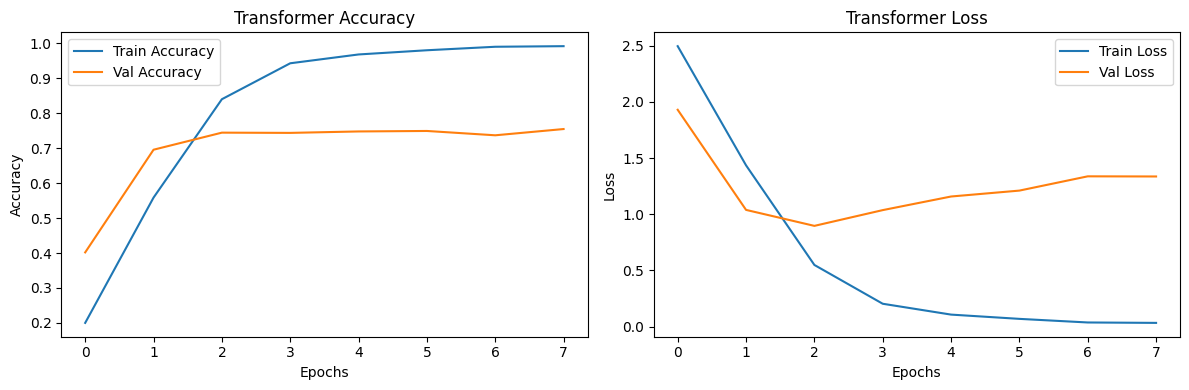

In [37]:


plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Transformer Accuracy')
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Transformer Loss')
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend()

plt.tight_layout()  # Adjust layout to fit into the figure area
plt.show()